In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

In [2]:

df = pd.read_csv('../data/heart_disease_selected.csv')
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (952, 11)
Testing set shape: (238, 11)


In [3]:

baseline_models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'SVM': SVC(random_state=42, probability=True)
}

# Parameter grids for GridSearchCV
param_grids = {
    'Logistic Regression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    },
    'Decision Tree': {
        'max_depth': [3, 5, 7, 10, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 15, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None]
    },
    'SVM': {
        'C': [0.1, 1, 10, 100],
        'kernel': ['rbf', 'linear'],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1]
    }
}


param_distributions = {
    'Logistic Regression': {
        'C': np.logspace(-4, 4, 20),
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    },
    'Decision Tree': {
        'max_depth': [3, 5, 7, 10, 15, 20, None],
        'min_samples_split': [2, 5, 10, 15, 20],
        'min_samples_leaf': [1, 2, 4, 6, 8],
        'criterion': ['gini', 'entropy']
    },
    'Random Forest': {
        'n_estimators': [50, 100, 150, 200, 250, 300],
        'max_depth': [5, 10, 15, 20, 25, None],
        'min_samples_split': [2, 5, 10, 15, 20],
        'min_samples_leaf': [1, 2, 4, 6, 8],
        'max_features': ['sqrt', 'log2', None]
    },
    'SVM': {
        'C': np.logspace(-2, 3, 20),
        'kernel': ['rbf', 'linear', 'poly'],
        'gamma': ['scale', 'auto'] + list(np.logspace(-4, 1, 10))
    }
}

In [4]:
baseline_results = {}

print("Baseline Model Performance:")
print("=" * 60)

for name, model in baseline_models.items():
    print(f"\n{name}:")
    print("-" * 30)
    
    # Train and predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    baseline_results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc
    }
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")

Baseline Model Performance:

Logistic Regression:
------------------------------
Accuracy: 0.8403
Precision: 0.8438
Recall: 0.8571
F1-Score: 0.8504
AUC: 0.9041

Decision Tree:
------------------------------
Accuracy: 0.8782
Precision: 0.8819
Recall: 0.8889
F1-Score: 0.8854
AUC: 0.8775

Random Forest:
------------------------------
Accuracy: 0.9160
Precision: 0.9344
Recall: 0.9048
F1-Score: 0.9194
AUC: 0.9736

SVM:
------------------------------
Accuracy: 0.8824
Precision: 0.8657
Recall: 0.9206
F1-Score: 0.8923
AUC: 0.9352


In [5]:
grid_results = {}
grid_models = {}

print("\n" + "=" * 60)
print("GridSearchCV Optimization")
print("=" * 60)

for name, model in baseline_models.items():
    print(f"\nOptimizing {name} with GridSearchCV...")
    print("-" * 50)
    
    # Perform GridSearchCV
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        cv=5,
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    # Get best model and predictions
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    grid_results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Best_Params': grid_search.best_params_
    }
    
    grid_models[name] = best_model
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test F1-Score: {f1:.4f}")


GridSearchCV Optimization

Optimizing Logistic Regression with GridSearchCV...
--------------------------------------------------
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'C': 0.001, 'penalty': 'l2', 'solver': 'saga'}
Best CV score: 0.8359
Test Accuracy: 0.8319
Test F1-Score: 0.8450

Optimizing Decision Tree with GridSearchCV...
--------------------------------------------------
Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV score: 0.8825
Test Accuracy: 0.8782
Test F1-Score: 0.8854

Optimizing Random Forest with GridSearchCV...
--------------------------------------------------
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best CV score: 0.9154
Test Accuracy: 0.9286
Test F1-Sco

In [6]:
random_results = {}
random_models = {}

print("\n" + "=" * 60)
print("RandomizedSearchCV Optimization")
print("=" * 60)

for name, model in baseline_models.items():
    print(f"\nOptimizing {name} with RandomizedSearchCV...")
    print("-" * 50)
    
    # Perform RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_distributions[name],
        n_iter=50,  # Number of parameter settings sampled
        cv=5,
        scoring='f1',
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
    
    random_search.fit(X_train, y_train)
    
    # Get best model and predictions
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    random_results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Best_Params': random_search.best_params_
    }
    
    random_models[name] = best_model
    
    print(f"Best parameters: {random_search.best_params_}")
    print(f"Best CV score: {random_search.best_score_:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test F1-Score: {f1:.4f}")


RandomizedSearchCV Optimization

Optimizing Logistic Regression with RandomizedSearchCV...
--------------------------------------------------
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'solver': 'saga', 'penalty': 'l1', 'C': np.float64(0.03359818286283781)}
Best CV score: 0.8429
Test Accuracy: 0.8487
Test F1-Score: 0.8583

Optimizing Decision Tree with RandomizedSearchCV...
--------------------------------------------------
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 10, 'criterion': 'gini'}
Best CV score: 0.8797
Test Accuracy: 0.8655
Test F1-Score: 0.8720

Optimizing Random Forest with RandomizedSearchCV...
--------------------------------------------------
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
Best CV 


COMPARISON OF ALL METHODS
                  Model  Accuracy Precision    Recall  F1-Score       AUC  \
0   Logistic Regression  0.840336   0.84375  0.857143  0.850394  0.904124   
1         Decision Tree  0.878151   0.88189  0.888889  0.885375   0.87748   
2         Random Forest  0.915966  0.934426  0.904762  0.919355  0.973604   
3                   SVM  0.882353  0.865672  0.920635  0.892308  0.935197   
4   Logistic Regression  0.831933  0.825758  0.865079  0.844961  0.906746   
5         Decision Tree  0.878151   0.88189  0.888889  0.885375   0.87748   
6         Random Forest  0.928571     0.936  0.928571  0.932271  0.971584   
7                   SVM  0.907563  0.919355  0.904762     0.912  0.920777   
8   Logistic Regression  0.848739  0.851562  0.865079  0.858268  0.907809   
9         Decision Tree  0.865546  0.879032  0.865079     0.872  0.879606   
10        Random Forest  0.915966  0.934426  0.904762  0.919355  0.973604   
11                  SVM  0.890756  0.916667  0.87

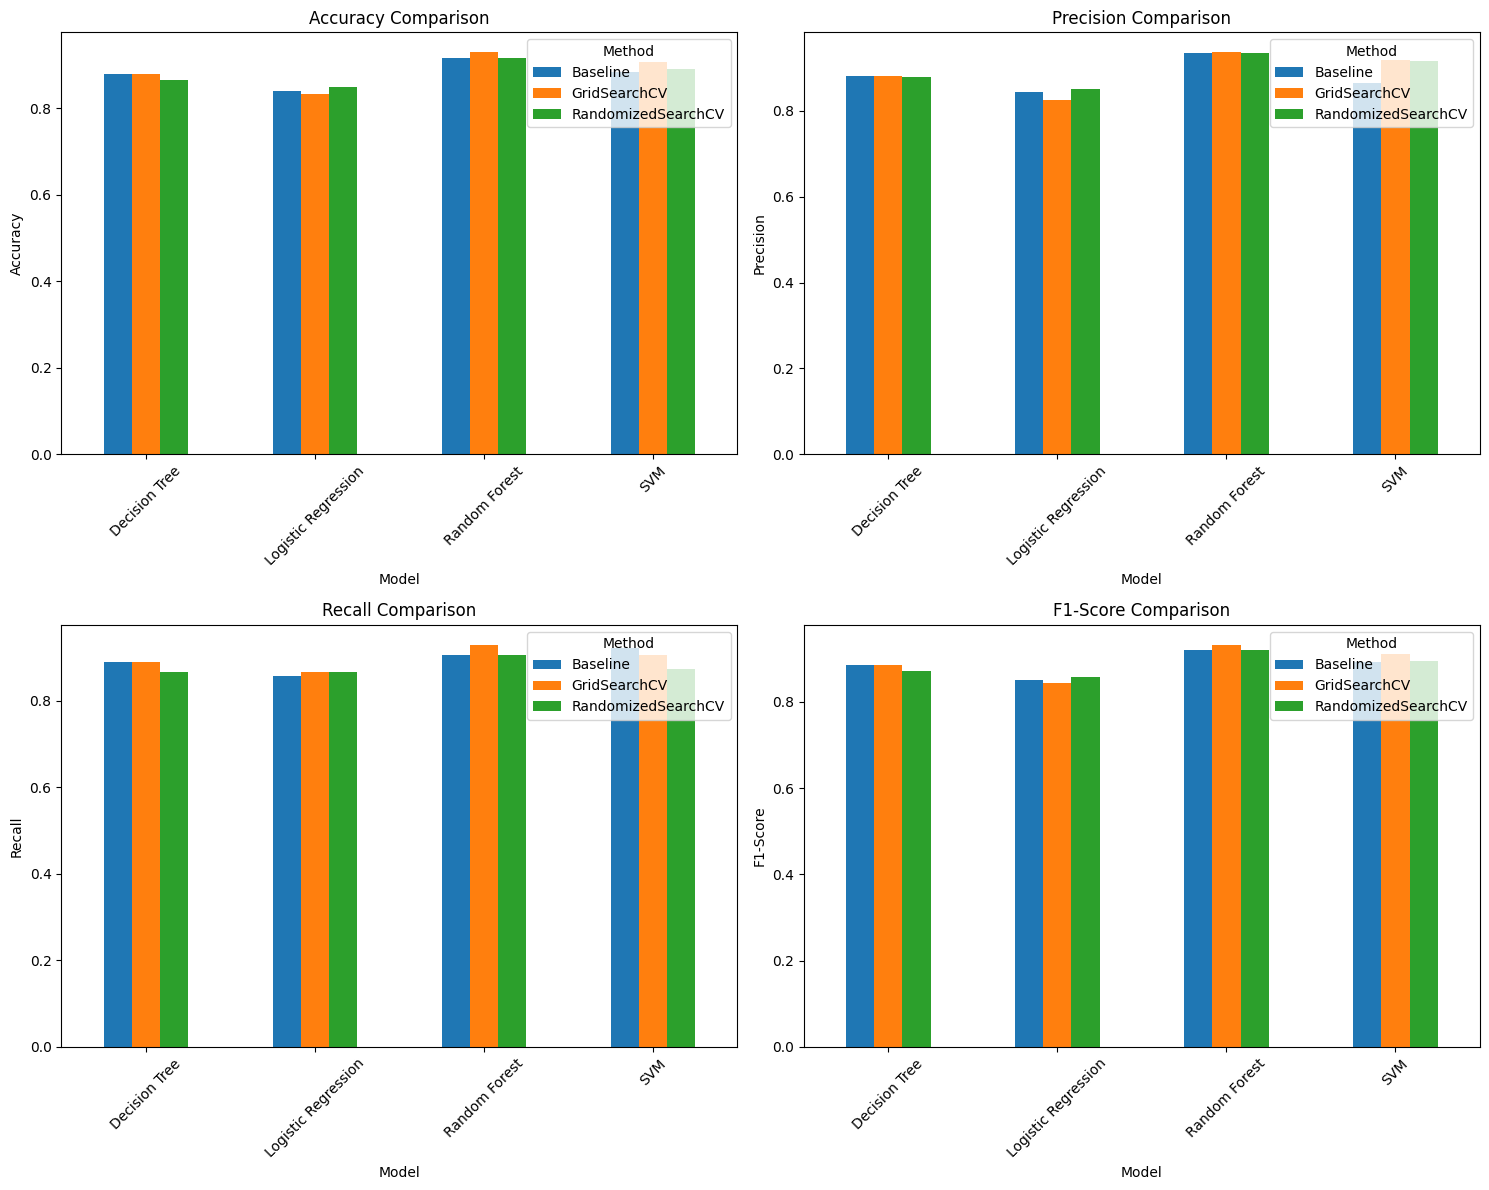

In [7]:
# Create comparison DataFrames
baseline_df = pd.DataFrame(baseline_results).T
grid_df = pd.DataFrame(grid_results).T.drop('Best_Params', axis=1)
random_df = pd.DataFrame(random_results).T.drop('Best_Params', axis=1)

# Add method labels
baseline_df['Method'] = 'Baseline'
grid_df['Method'] = 'GridSearchCV'
random_df['Method'] = 'RandomizedSearchCV'

# Combine results
all_results = pd.concat([baseline_df, grid_df, random_df])
all_results = all_results.reset_index().rename(columns={'index': 'Model'})

print("\n" + "=" * 80)
print("COMPARISON OF ALL METHODS")
print("=" * 80)
print(all_results.round(4))

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]
    
    # Create pivot table for plotting
    pivot_data = all_results.pivot(index='Model', columns='Method', values=metric)
    pivot_data.plot(kind='bar', ax=ax)
    
    ax.set_title(f'{metric} Comparison')
    ax.set_ylabel(metric)
    ax.legend(title='Method')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [8]:
# Find best model based on F1-Score
best_overall = all_results.loc[all_results['F1-Score'].idxmax()]
print(f"\n{'='*60}")
print("BEST OVERALL MODEL")
print(f"{'='*60}")
print(f"Model: {best_overall['Model']}")
print(f"Method: {best_overall['Method']}")
print(f"F1-Score: {best_overall['F1-Score']:.4f}")
print(f"Accuracy: {best_overall['Accuracy']:.4f}")
print(f"Precision: {best_overall['Precision']:.4f}")
print(f"Recall: {best_overall['Recall']:.4f}")
print(f"AUC: {best_overall['AUC']:.4f}")

# Get the best model
if best_overall['Method'] == 'GridSearchCV':
    best_model = grid_models[best_overall['Model']]
    best_params = grid_results[best_overall['Model']]['Best_Params']
elif best_overall['Method'] == 'RandomizedSearchCV':
    best_model = random_models[best_overall['Model']]
    best_params = random_results[best_overall['Model']]['Best_Params']
else:
    best_model = baseline_models[best_overall['Model']]
    best_params = "Default parameters"

print(f"\nBest Parameters: {best_params}")


BEST OVERALL MODEL
Model: Random Forest
Method: GridSearchCV
F1-Score: 0.9323
Accuracy: 0.9286
Precision: 0.9360
Recall: 0.9286
AUC: 0.9716

Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [9]:
# Save all results
all_results.to_csv('../results/hyperparameter_tuning_results.csv', index=False)
print("\nResults saved to '../results/hyperparameter_tuning_results.csv'")

# Save best model
import joblib
joblib.dump(best_model, '../models/optimized_best_model.pkl')
print("Best optimized model saved to '../models/optimized_best_model.pkl'")

# Save best parameters
import json
with open('../results/best_parameters.json', 'w') as f:
    json.dump(best_params, f, indent=4)
print("Best parameters saved to '../results/best_parameters.json'")


Results saved to '../results/hyperparameter_tuning_results.csv'
Best optimized model saved to '../models/optimized_best_model.pkl'
Best parameters saved to '../results/best_parameters.json'


In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import joblib

# Define the feature order (must match your app and raw CSV)
feature_names = [
    'age', 'sex', 'chest_pain_type', 'resting_bp_s', 'cholesterol',
    'fasting_blood_sugar', 'resting_ecg', 'max_heart_rate', 'exercise_angina',
    'oldpeak', 'st_slope'
]

# Load your raw data (not preprocessed)
df = pd.read_csv('../data/heart_disease.csv')
X = df[feature_names]
y = df['target']

# Use your best model from hyperparameter tuning
# For example, if you have best_model from GridSearchCV or RandomizedSearchCV:
# best_model = grid_search.best_estimator_

# Create a pipeline: scaler + model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', best_model)
])

# Fit the pipeline on the full data (or train/test split as appropriate)
pipeline.fit(X, y)

# Save the pipeline
joblib.dump(pipeline, '../models/heart_disease_pipeline.pkl')
print("Pipeline saved to ../models/heart_disease_pipeline.pkl")

Pipeline saved to ../models/heart_disease_pipeline.pkl


In [11]:
# Check model predictions for young, healthy cases
young_healthy = df[(df['age'] < 30) & (df['target'] == 0)]
X_young_healthy = young_healthy[feature_names]
y_pred = pipeline.predict(X_young_healthy)
y_proba = pipeline.predict_proba(X_young_healthy)
print('Probabilities for young healthy:')
for i, proba in enumerate(y_proba):
    print(f"Index {young_healthy.index[i]} | Prob (No Disease, Disease): {proba}")

Probabilities for young healthy:
Index 171 | Prob (No Disease, Disease): [1. 0.]
Index 209 | Prob (No Disease, Disease): [0.92 0.08]
Index 220 | Prob (No Disease, Disease): [1. 0.]
Index 831 | Prob (No Disease, Disease): [0.98 0.02]
Index 1019 | Prob (No Disease, Disease): [0.98 0.02]


In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(class_weight='balanced', random_state=42))
])
pipeline.fit(X, y)
import joblib
joblib.dump(pipeline, '../models/heart_disease_pipeline.pkl')

['../models/heart_disease_pipeline.pkl']